In [1]:
import os
import pandas as pd
import torchaudio
from datasets import Dataset, DatasetDict, Audio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, TrainingArguments, Trainer, DataCollatorForTokenClassification, EarlyStoppingCallback
import numpy as np
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from jiwer import wer
import matplotlib.pyplot as plt
import json

In [2]:
# Dataset's Path
BASE_PATH = "Dataset/HF_id"
AUDIO_DIR = os.path.join(BASE_PATH, "audio")
SAMPLE_RATE = 16000

In [3]:
# Load TSV File
def load_fleurs_tsv(tsv_path, split_name):
    df = pd.read_csv(tsv_path, sep='\t', header=None)
    df.columns = ["index", "file", "raw_text", "normalized_text", "phoneme", "duration", "gender"]
    
    # Prefix the audio path with split folder name
    df["file"] = df["file"].apply(lambda x: os.path.join(AUDIO_DIR, split_name, x))
    
    return df[["file", "normalized_text"]].rename(columns={"file": "audio", "normalized_text": "sentence"})

In [4]:
# Load datasets
train_df = load_fleurs_tsv(os.path.join(BASE_PATH, "train.tsv"), "train")
dev_df = load_fleurs_tsv(os.path.join(BASE_PATH, "dev.tsv"), "dev")
test_df = load_fleurs_tsv(os.path.join(BASE_PATH, "test.tsv"), "test")

In [5]:
df_train = pd.read_csv(os.path.join(BASE_PATH, "train.tsv"), sep='\t', header=None, dtype=str)

df_train[5] = pd.to_numeric(df_train[5], errors='coerce')  # 'coerce' if value not valid convert to NaN

SAMPLE_RATE = 16000 

def convert_duration_to_seconds(duration_value):
    if pd.isna(duration_value):
        return 0  # If NaN, 0 second
    return duration_value / SAMPLE_RATE

# Sum total duration dataset (second)
total_duration_seconds = df_train[5].apply(convert_duration_to_seconds).sum()

# Sum of valid entry
valid_entries = df_train[5].notna().sum()

total_duration_hours = total_duration_seconds / 3600

print(f'Total dataset duration (from {valid_entries} valid entries): {total_duration_hours:.2f} hours')

Total dataset duration (from 2560 valid entries): 9.01 hours


In [6]:
# Convert to HF Dataset
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
    "test": test_dataset
})

In [7]:
# Add Audio column
dataset = dataset.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

In [8]:
# Load processor
processor = Wav2Vec2Processor.from_pretrained("./Wav2Vec2.0-id-Model")

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [9]:
# Preprocessing audio and text
def prepare_dataset(batch):
    # extract input features
    inputs = processor(batch["audio"]["array"], sampling_rate=batch["audio"]["sampling_rate"])
    
    # extract label
    with processor.as_target_processor():
        labels = processor(batch["sentence"]).input_ids

    batch["input_values"] = inputs.input_values[0]
    batch["attention_mask"] = inputs.attention_mask[0]
    batch["labels"] = labels
    return batch

In [10]:
# Map preprocessing to all splits
ds = dataset.map(prepare_dataset, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/2579 [00:00<?, ? examples/s]

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

In [11]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained("./Wav2Vec2.0-id-Model")
model.freeze_feature_encoder()

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [12]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features):
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.tokenizer.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

In [13]:
# METRICS FUNCTION (WER dan Accuracy)
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred_str = processor.batch_decode(pred_ids)
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)

    wer_score = wer(label_str, pred_str)

    acc = np.mean([
        p.strip() == l.strip()
        for p, l in zip(pred_str, label_str)
    ])
    return {"wer": wer_score, "accuracy": acc}

In [14]:
training_args = TrainingArguments(
    output_dir="./wav2vec2-finetuned-id",
    per_device_train_batch_size=2,  # Bisa diturunkan ke 2 jika OOM
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Untuk meniru batch yang lebih besar
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,  # Paper menyarankan antara 500-1000
    eval_steps=500,
    logging_steps=100,
    num_train_epochs=30,  # Sesuai paper
    gradient_checkpointing=True,  # Menghemat VRAM
    fp16=True,  # Memanfaatkan mixed precision training
    learning_rate=2e-5,  # Paper menyarankan 1e-5 hingga 4e-5, jadi pakai 3e-5
    warmup_steps=500,  # Lebih tinggi untuk stabilitas awal
    weight_decay=0.005,  # Sesuai paper
    save_total_limit=None,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False
)

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
data_collator = DataCollatorCTCWithPadding(processor=processor)

In [16]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

C:\Users\dephm\AppData\Local\Temp\ipykernel_21044\1611929361.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
# TRAIN & CATCH OOM ERROR [FINE TUNING]
try:
    trainer.train()
except RuntimeError as e:
    if "out of memory" in str(e):
        print("CUDA OOM:  Reduce batch size")
    else:
        raise e

Step,Training Loss,Validation Loss,Wer,Accuracy
500,0.836000,0.467651,0.456525,0.000000
1000,0.685400,0.403047,0.428431,0.000000
1500,0.631700,0.388162,0.404692,0.000000
2000,0.591400,0.363615,0.399916,0.000000
2500,0.581000,0.374191,0.391347,0.000000
3000,0.529200,0.366954,0.392471,0.000000
3500,0.532600,0.377053,0.385026,0.000000
4000,0.526800,0.375307,0.382498,0.000000
4500,0.529200,0.367832,0.380250,0.000000


d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can

In [18]:
# SAVE METRICS TO FILE
metrics = trainer.state.log_history

with open("training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

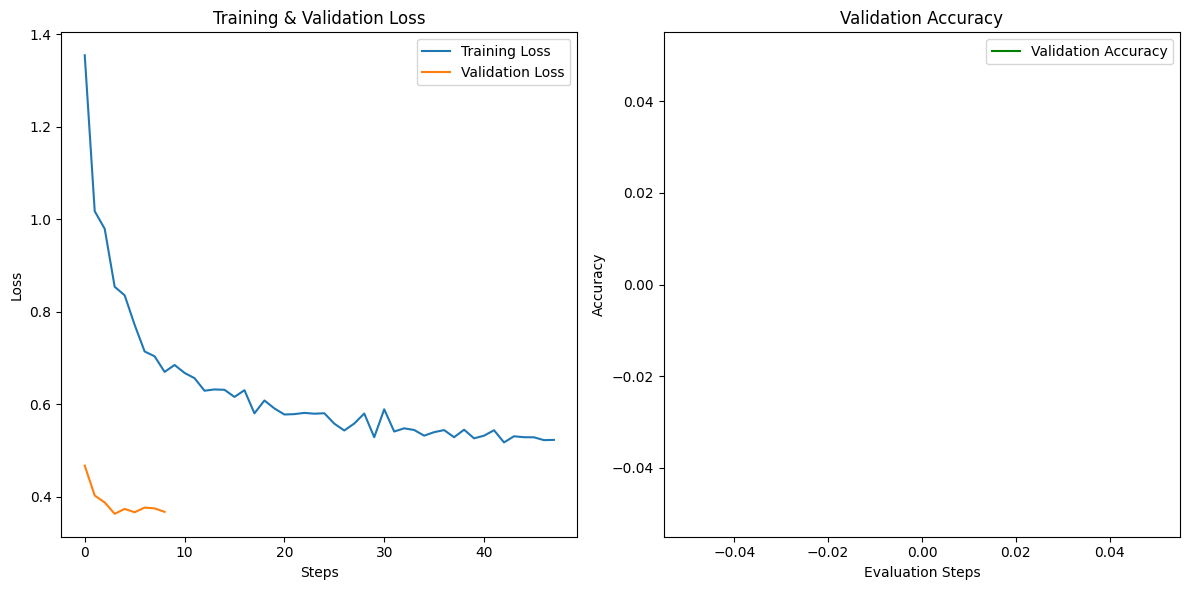

In [19]:
# PLOTTING
train_loss = [m["loss"] for m in metrics if "loss" in m and "eval_loss" not in m]
eval_loss = [m["eval_loss"] for m in metrics if "eval_loss" in m]
accuracy = [m["accuracy"] for m in metrics if "accuracy" in m]

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label="Validation Accuracy", color="green")
plt.xlabel("Evaluation Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

In [20]:
import json

with open("./wav2vec2-finetuned-id/checkpoint-4830/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

# Ambil training loss dan evaluation loss dari logs
train_loss = []
eval_loss = []
accuracy = []

for log in trainer_state["log_history"]:
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_wer" in log:
        accuracy.append(1 - log["eval_wer"])  # Jika WER, maka akurasi = 1 - WER


In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load trainer state dari checkpoint
with open("./wav2vec2-finetuned-id/checkpoint-4830/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

# Inisialisasi list untuk menyimpan data
train_loss = []
train_x = []
eval_loss = []
eval_x = []
accuracy = []
accuracy_x = []

# Untuk grafik berdasarkan epoch
train_loss_epoch = []
eval_loss_epoch = []
accuracy_epoch = []
epoch_list = []

# Loop semua log untuk ambil data
for log in trainer_state["log_history"]:
    if "loss" in log:
        train_loss.append(log["loss"])
        train_x.append(log["step"])
        if "epoch" in log:
            train_loss_epoch.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_x.append(log["step"])
        if "epoch" in log:
            eval_loss_epoch.append(log["eval_loss"])
            epoch_list.append(log["epoch"])
    if "eval_wer" in log:
        accuracy.append(1 - log["eval_wer"])
        accuracy_x.append(log["step"])
        if "epoch" in log:
            accuracy_epoch.append(1 - log["eval_wer"])

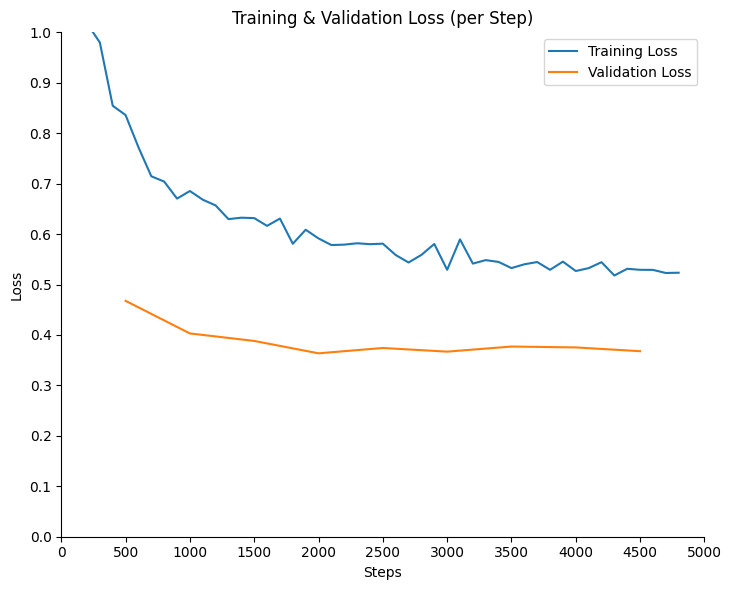

In [22]:
plt.figure(figsize=(14, 6))

# Loss Plot (Steps)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(train_x, train_loss, label="Training Loss")
ax1.plot(eval_x, eval_loss, label="Validation Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss (per Step)")
ax1.legend()
ax1.grid(False)
ax1.set_ylim(0, 1)
ax1.set_xlim(0, 5000)
ax1.set_xticks(np.arange(0, 5001, 500))
ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("training_plot_by_step.png")
plt.show()

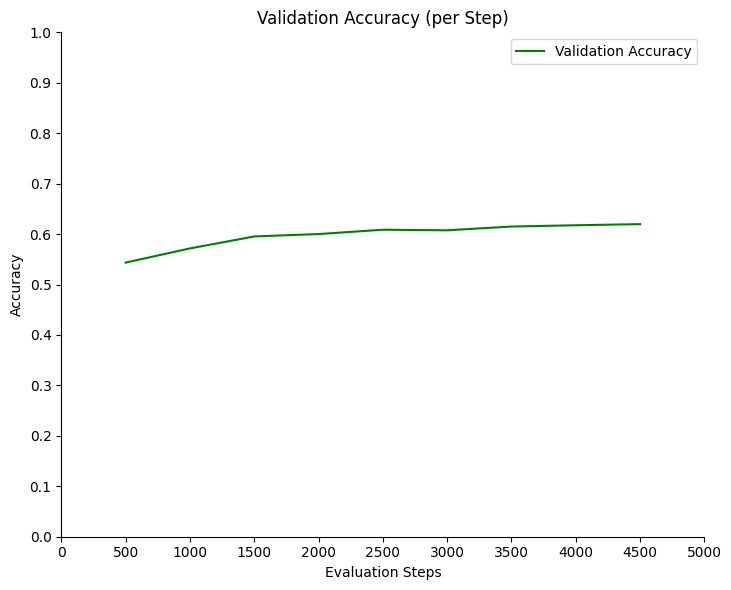

In [23]:
plt.figure(figsize=(14, 6))

# Accuracy Plot (Steps)
ax2 = plt.subplot(1, 2, 2)
ax2.plot(accuracy_x, accuracy, label="Validation Accuracy", color="green")
ax2.set_xlabel("Evaluation Steps")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation Accuracy (per Step)")
ax2.legend()
ax2.grid(False)
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 5000)
ax2.set_xticks(np.arange(0, 5001, 500))
ax2.set_yticks(np.arange(0, 1.01, 0.1))
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("validation_plot_by_step.png")
plt.show()

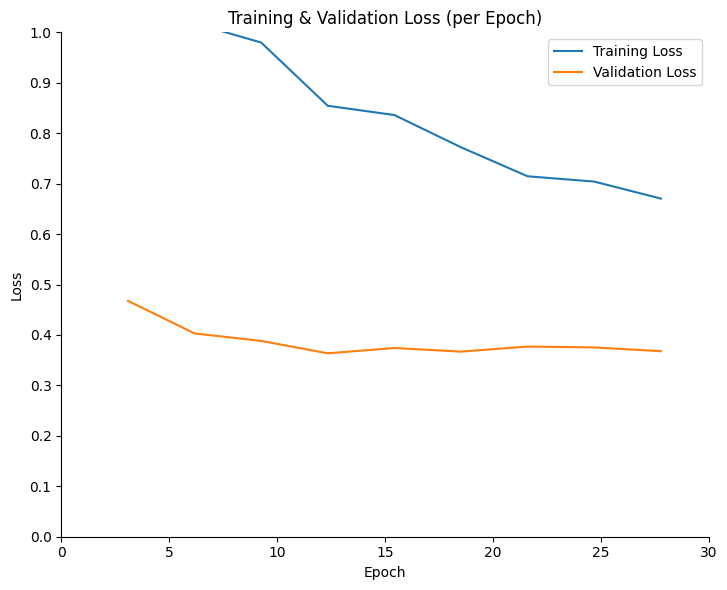

In [24]:
plt.figure(figsize=(14, 6))

# Loss Plot (Epoch)
ax3 = plt.subplot(1, 2, 1)
ax3.plot(epoch_list, train_loss_epoch[:len(epoch_list)], label="Training Loss")
ax3.plot(epoch_list, eval_loss_epoch, label="Validation Loss")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Loss")
ax3.set_title("Training & Validation Loss (per Epoch)")
ax3.legend()
ax3.grid(False)
ax3.set_ylim(0, 1)
ax3.set_xlim(0, 30)
ax3.set_xticks(np.arange(0, 31, 5))
ax3.set_yticks(np.arange(0, 1.01, 0.1))
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("training_plot_by_epoch.png")
plt.show()

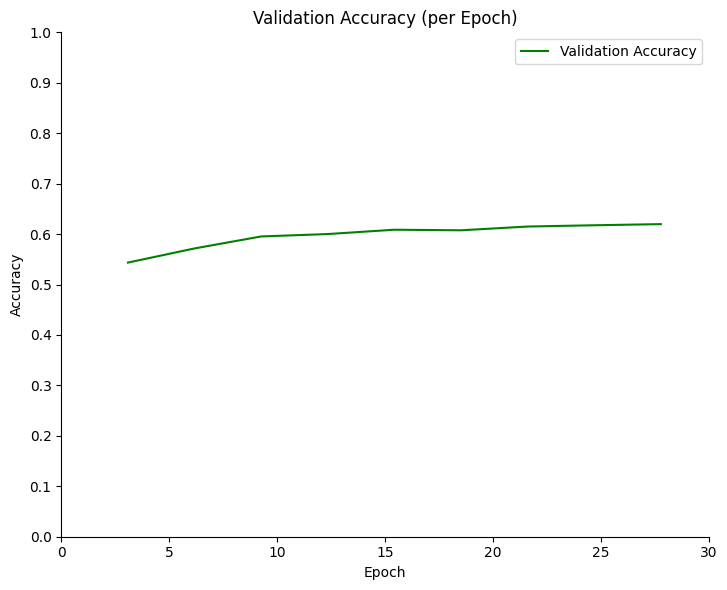

In [25]:
plt.figure(figsize=(14, 6))

# Accuracy Plot (Epoch)
ax4 = plt.subplot(1, 2, 2)
ax4.plot(epoch_list, accuracy_epoch, label="Validation Accuracy", color="green")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Accuracy")
ax4.set_title("Validation Accuracy (per Epoch)")
ax4.legend()
ax4.grid(False)
ax4.set_ylim(0, 1)
ax4.set_xlim(0, 30)
ax4.set_xticks(np.arange(0, 31, 5))
ax4.set_yticks(np.arange(0, 1.01, 0.1))
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("Accuracty_plot_by_epoch.png")
plt.show()

In [26]:
model.save_pretrained("./wav2vec2-finetuned-id/final")
processor.save_pretrained("./wav2vec2-finetuned-id/final")

[]

In [ ]:
# Fine-tuning
# trainer.train()

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.696600,0.420477
1000,0.597100,0.402975
1500,0.540700,0.376387
2000,0.546100,0.376483


d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [2]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("./wav2vec2-finetuned-id/final")

In [3]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - Trainable")
    else:
        print(f"{name} - Frozen")

wav2vec2.masked_spec_embed - Trainable
wav2vec2.feature_extractor.conv_layers.0.conv.weight - Trainable
wav2vec2.feature_extractor.conv_layers.0.conv.bias - Trainable
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight - Trainable
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias - Trainable
wav2vec2.feature_extractor.conv_layers.1.conv.weight - Trainable
wav2vec2.feature_extractor.conv_layers.1.conv.bias - Trainable
wav2vec2.feature_extractor.conv_layers.1.layer_norm.weight - Trainable
wav2vec2.feature_extractor.conv_layers.1.layer_norm.bias - Trainable
wav2vec2.feature_extractor.conv_layers.2.conv.weight - Trainable
wav2vec2.feature_extractor.conv_layers.2.conv.bias - Trainable
wav2vec2.feature_extractor.conv_layers.2.layer_norm.weight - Trainable
wav2vec2.feature_extractor.conv_layers.2.layer_norm.bias - Trainable
wav2vec2.feature_extractor.conv_layers.3.conv.weight - Trainable
wav2vec2.feature_extractor.conv_layers.3.conv.bias - Trainable
wav2vec2.feature_extractor.co

In [4]:
base_model = Wav2Vec2ForCTC.from_pretrained("Wav2Vec2.0-id-Model")

d:\Tugas Akhir\STT-1\Fine-Tuning\finetune-env\Lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
import torch
base_lm = base_model.lm_head.state_dict()
finetuned_lm = model.lm_head.state_dict()

# Cek perbedaannya
for key in base_lm:
    if not torch.equal(base_lm[key], finetuned_lm[key]):
        print(f"{key} has changed.")
    else:
        print(f"{key} is unchanged.")

weight has changed.
bias has changed.


In [6]:
print(model)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [12]:
print(model.lm_head)

Linear(in_features=1024, out_features=28, bias=True)


In [13]:
print(base_model)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [14]:
print(base_model.lm_head)

Linear(in_features=1024, out_features=28, bias=True)
